In [41]:
import pandas as pd
import numpy as np
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv('heart.csv')
df.columns = df.columns.str.strip()
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)


In [43]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

X['FastingBS'] = X['FastingBS'].astype(str)

print(f"Features numéricas identificadas: {numerical_features}")
print(f"Features categóricas identificadas: {categorical_features}\n")

Features numéricas identificadas: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
Features categóricas identificadas: ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']



In [44]:
# 3. Construção do Pipeline de Pré-processamento
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [45]:
X_processed = preprocessor.fit_transform(X)


In [46]:
processed_cat_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
new_column_names = numerical_features + list(processed_cat_cols)

df_processed = pd.DataFrame(X_processed, columns=new_column_names)

print("- Dados Após o Pré-processamento ")
print(f"Shape dos dados processados: {df_processed.shape}")
print("Visualização das 5 primeiras linhas dos dados prontos para o modelo:")
print(df_processed.head())

- Dados Após o Pré-processamento 
Shape dos dados processados: (918, 18)
Visualização das 5 primeiras linhas dos dados prontos para o modelo:
        Age  RestingBP  Cholesterol     MaxHR   Oldpeak  Sex_ M    \
0 -1.433140   0.410909     0.801997  1.382928 -0.832432       1.0   
1 -0.478484   1.491752    -1.190590  0.754157  0.105664       0.0   
2 -1.751359  -0.129513     0.692314 -1.525138 -0.832432       1.0   
3 -0.584556   0.302825    -0.569049 -1.132156  0.574711       0.0   
4  0.051881   0.951331    -0.916381 -0.581981 -0.832432       1.0   

   ChestPainType_ ASY            ChestPainType_ ATA            \
0                           0.0                           1.0   
1                           0.0                           0.0   
2                           0.0                           1.0   
3                           1.0                           0.0   
4                           0.0                           0.0   

   ChestPainType_ NAP            ChestPainType_ TA  

In [47]:
# 6. Divisão dos Dados, Treinamento e Avaliação do Modelo 
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

print("- Dados divididos em conjuntos de treino e teste")
print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras\n")

- Dados divididos em conjuntos de treino e teste
Tamanho do conjunto de treino: 734 amostras
Tamanho do conjunto de teste: 184 amostras



In [48]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)


KNeighborsClassifier()

In [49]:
y_pred = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("- Métricas de Avaliação do Modelo KNN ")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}\n")

print("- Relatório de Classificação ")
print(classification_report(y_test, y_pred, target_names=['Não Doente (0)', 'Doente (1)']))



- Métricas de Avaliação do Modelo KNN 
Acurácia: 0.8696
Precisão: 0.8900
Recall: 0.8725
F1-Score: 0.8812

- Relatório de Classificação 
                precision    recall  f1-score   support

Não Doente (0)       0.85      0.87      0.86        82
    Doente (1)       0.89      0.87      0.88       102

      accuracy                           0.87       184
     macro avg       0.87      0.87      0.87       184
  weighted avg       0.87      0.87      0.87       184



- Matriz de Confusão


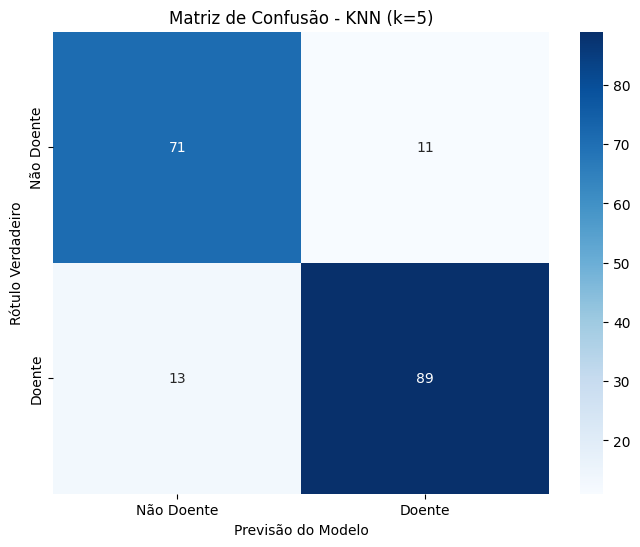

In [50]:
print("- Matriz de Confusão")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Doente', 'Doente'], 
            yticklabels=['Não Doente', 'Doente'])
            
plt.xlabel('Previsão do Modelo')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão - KNN (k=5)')
plt.show()

[('ST_Slope_ Up       <= 0.00', 0.20602835878990913), ('0.00 < ST_Slope_ Flat     <= 1.00', 0.1849415408621309), ('MaxHR <= -0.70', 0.18220916405799642), ('0.00 < ChestPainType_ ASY           <= 1.00', 0.1601142272884771), ('ChestPainType_ ATA           <= 0.00', 0.125226119738559), ('0.00 < ExerciseAngina_ Y              <= 1.00', 0.12037790035916411), ('FastingBS_1 <= 0.00', -0.0943005563535316), ('ChestPainType_ NAP           <= 0.00', 0.08084334545454461), ('-0.08 < Cholesterol <= 0.53', 0.05578262279907217), ('ST_Slope_ Down     <= 0.00', -0.03814135570449481)]


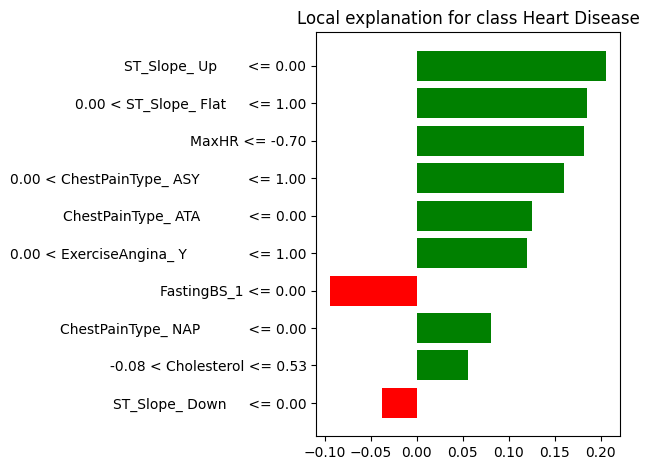

In [51]:
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=new_column_names,
    class_names=['No Heart Disease', 'Heart Disease'],
    mode='classification'
)
idx = 0
exp = explainer.explain_instance(
    data_row=X_test[idx],
    predict_fn=knn_model.predict_proba
)
print(exp.as_list())
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()


In [54]:
perm_importance = permutation_importance(
    knn_model, X_test, y_test, n_repeats=15, random_state=42, scoring='accuracy'
)

In [55]:
perm_df = pd.DataFrame({
    'feature': new_column_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

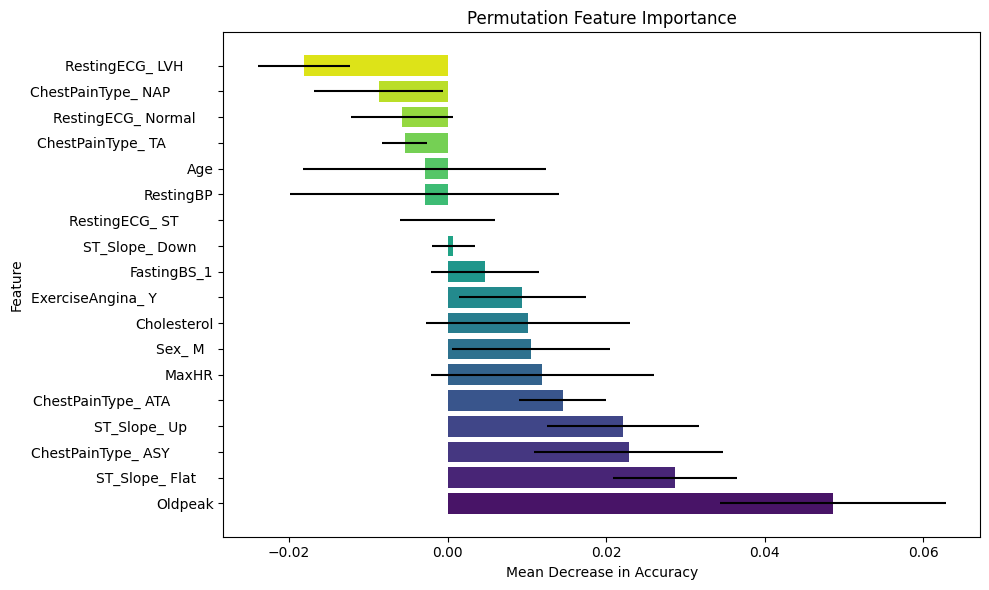

In [57]:
plt.figure(figsize=(10,6))
plt.barh(
    y=perm_df['feature'],
    width=perm_df['importance_mean'],
    xerr=perm_df['importance_std'],
    color=sns.color_palette("viridis", len(perm_df))
)
plt.xlabel("Mean Decrease in Accuracy")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()